Want classifier to quantify its uncertainty.
<br>Helpful to decide when to hand control to humans.
<br><br>
SNGP = Spectral-normalized Neural Gaussian Process
<br>Improves "distance awarenes", which measures how the predicted probabilities reflect the distance b/w the test sample and the training data.
<br>This property is already in models such as Gaussian process with RBF kernels, but not in NNs.
<br><br>
Other popular approaches:
 - Monte Carlo dropout
 - Deep ensemble

SNGP:
<br>Applies spectral normalization to hidden residual layers
<br>Replace Dense output with Gaussian process layer
<br>
Advantages:
 - Applicable to wide range of SOTA residual-based architectures
 - Does not rely on ensemble averaging, so it's latency is scalable
 - Strong out-of-domain detection due to distance-awareness
 <br>


 Disadvantages:
  - Uncertainty is calculated using Laplace approximation, so it's different from an exact Gaussian process
  - It needs a covariance reset step at the start of each epoch, which adds extra complexity.

In [1]:
#!pip install -U --use-deprecated=legacy-resolver tf-models-official tensorflow
!pip install -U tf-models-official tensorflow tf-keras

  Using cached tensorflow-2.17.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (601.3 MB)
  Using cached tf_keras-2.17.0-py3-none-any.whl (1.7 MB)
INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.


In [2]:
import pkg_resources
import importlib

importlib.reload(pkg_resources)  # refresh it so it takes the changes into account

<module 'pkg_resources' from '/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py'>

In [3]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import sklearn.datasets

import numpy as np
import tensorflow as tf
import tf_keras
import official.nlp.modeling.layers as nlp_layers

In [4]:
# needed to add these
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

In [5]:
plt.rcParams['figure.dpi'] = 140

DEFAULT_X_RANGE= (-3.5, 3.5)
DEFAULT_Y_RANGE = (-2.5, 2.5)
DEFAULT_CMAP = colors.ListedColormap(['#377eb8', '#ff7f00'])
DEFAULT_NORM = colors.Normalize(vmin=0, vmax=1)
DEFAULT_N_GRID = 100

In [6]:
def make_training_data(sample_size=500):
  train_examples, train_labels = sklearn.datasets.make_moons(
      n_samples=2*sample_size, noise=0.1
  )

  # adjust data position
  train_examples[train_labels == 0] += [-0.1, 0.2]
  train_examples[train_labels == 1] += [0.1, -0.2]

  return train_examples, train_labels

def make_testing_data(x_range=DEFAULT_X_RANGE, y_range=DEFAULT_Y_RANGE, n_grid=DEFAULT_N_GRID):
  # evaluate predictions over entire 2D input space
  x = np.linspace(x_range[0], x_range[1], n_grid)
  y = np.linspace(y_range[0], y_range[1], n_grid)

  xv, yv = np.meshgrid(x, y)

  return np.stack([xv.flatten(), yv.flatten()], axis=-1)

def make_ood_data(sample_size=500, means=(2.5, -1.75), vars=(0.01, 0.01)):
  # to evaluate model uncertainty, add OOD dataset that belongs to a third class
  return np.random.multivariate_normal(
      means, cov=np.diag(vars), size=sample_size
  )

In [7]:
train_examples, train_labels = make_training_data(sample_size=500)
test_examples = make_testing_data()
ood_examples = make_ood_data()

pos_ex = train_examples[train_labels == 0]
neg_ex = train_examples[train_labels == 1]

<Figure size 980x770 with 0 Axes>

(-2.5, 2.5)

(-3.5, 3.5)

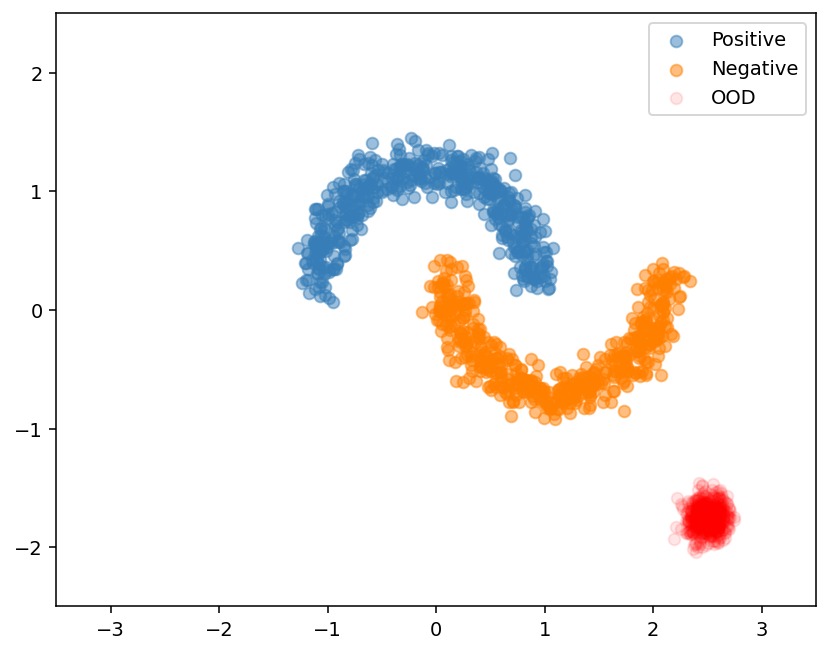

In [8]:
# visualize

plt.figure(figsize=(7, 5.5))

plt.scatter(pos_ex[:, 0], pos_ex[:, 1], c='#377eb8', alpha=0.5)
plt.scatter(neg_ex[:, 0], neg_ex[:, 1], c='#ff7f00', alpha=0.5)
plt.scatter(ood_examples[:, 0], ood_examples[:, 1], c='red', alpha=0.1)

plt.legend(["Positive", "Negative", "OOD"])

plt.ylim(DEFAULT_Y_RANGE)
plt.xlim(DEFAULT_X_RANGE)

plt.show()

Visualize and check normal model first (w/o SNGP modifications)

In [9]:
# base model
class DeepResNet(tf_keras.Model):
  def __init__(self, num_classes, num_layers=3, num_hidden=128,
               dropout_rate=0.1, **classifier_kwargs):
    super().__init__()

    self.num_layers = num_layers
    self.num_hidden = num_hidden
    self.dropout_rate = dropout_rate
    self.classifier_kwargs = classifier_kwargs

    self.input_layer = tf_keras.layers.Dense(self.num_hidden, trainable=False)
    self.dense_layers = [self.make_dense_layer() for _ in range(self.num_layers)]
    self.dropouts = [self.make_dropout() for _ in range(self.num_layers)]
    self.classifier = self.make_output_layer(num_classes)

  def make_dense_layer(self):
    return tf_keras.layers.Dense(self.num_hidden, activation='relu')

  def make_dropout(self):
    return tf_keras.layers.Dropout(self.dropout_rate)

  def make_output_layer(self, num_classes):
    return tf_keras.layers.Dense(num_classes, **self.classifier_kwargs)

  def call(self, inputs):
    hidden = self.input_layer(inputs)

    for i in range(self.num_layers):
      resid = self.dense_layers[i](hidden)
      resid = self.dropouts[i](resid)
      hidden += resid

    return self.classifier(hidden)

In [10]:
resnet_config = dict(num_classes=2, num_layers=6, num_hidden=128)

resnet_model = DeepResNet(**resnet_config)

resnet_model.build((None, 2))
resnet_model.summary()

Model: "deep_res_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               multiple                  384       
                                                                 
 dense_1 (Dense)             multiple                  16512     
                                                                 
 dense_2 (Dense)             multiple                  16512     
                                                                 
 dense_3 (Dense)             multiple                  16512     
                                                                 
 dense_4 (Dense)             multiple                  16512     
                                                                 
 dense_5 (Dense)             multiple                  16512     
                                                                 
 dense_6 (Dense)             multiple                 

In [11]:
loss = tf_keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = [tf_keras.metrics.SparseCategoricalAccuracy()]
optimizer = tf_keras.optimizers.legacy.Adam(learning_rate=1e-4)

train_config = dict(loss=loss, metrics=metrics, optimizer=optimizer)
fit_config = dict(batch_size=128, epochs=100)

In [12]:
resnet_model.compile(**train_config)
resnet_model.fit(train_examples, train_labels, **fit_config)

Epoch 1/100
8/8 [==============================] - 48s 11ms/step - loss: 0.4816 - sparse_categorical_accuracy: 0.7770
Epoch 2/100
8/8 [==============================] - 0s 11ms/step - loss: 0.2636 - sparse_categorical_accuracy: 0.9130
Epoch 3/100
8/8 [==============================] - 0s 10ms/step - loss: 0.1895 - sparse_categorical_accuracy: 0.9260
Epoch 4/100
8/8 [==============================] - 0s 9ms/step - loss: 0.1525 - sparse_categorical_accuracy: 0.9370
Epoch 5/100
8/8 [==============================] - 0s 9ms/step - loss: 0.1407 - sparse_categorical_accuracy: 0.9410
Epoch 6/100
8/8 [==============================] - 0s 9ms/step - loss: 0.1221 - sparse_categorical_accuracy: 0.9540
Epoch 7/100
8/8 [==============================] - 0s 10ms/step - loss: 0.1199 - sparse_categorical_accuracy: 0.9480
Epoch 8/100
8/8 [==============================] - 0s 9ms/step - loss: 0.1174 - sparse_categorical_accuracy: 0.9460
Epoch 9/100
8/8 [==============================] - 0s 9ms/step - lo

In [13]:
def plot_uncertainty_surface(test_uncertainty, ax, cmap=None):
  test_uncertainty = test_uncertainty / np.max(test_uncertainty)

  ax.set_ylim(DEFAULT_Y_RANGE)
  ax.set_xlim(DEFAULT_X_RANGE)

  pcm = ax.imshow(
      np.reshape(test_uncertainty, [DEFAULT_N_GRID, DEFAULT_N_GRID]),
      cmap=cmap,
      origin='lower',
      extent=DEFAULT_X_RANGE + DEFAULT_Y_RANGE,
      vmin=DEFAULT_NORM.vmin,
      vmax=DEFAULT_NORM.vmax,
      interpolation='bicubic',
      aspect='auto'
  )

  ax.scatter(train_examples[:, 0], train_examples[:, 1], c=train_labels, cmap=DEFAULT_CMAP, alpha=0.5)
  ax.scatter(ood_examples[:, 0], ood_examples[:, 1], c='red', alpha=0.1)

  return pcm

In [14]:
resnet_logits = resnet_model(test_examples)
# get prob for class 0
resnet_probs = tf.nn.softmax(resnet_logits, axis=-1)[:, 0]

Text(0.5, 1.0, 'Class Probability, Deterministic Model')

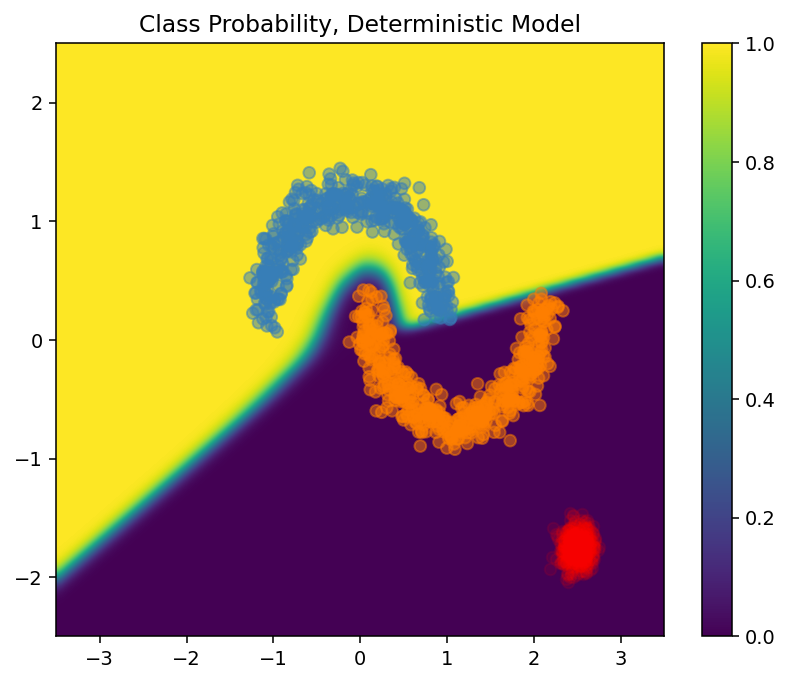

In [15]:
_, ax = plt.subplots(figsize=(7, 5.5))

pcm = plot_uncertainty_surface(resnet_probs, ax=ax)
plt.colorbar(pcm, ax=ax)
plt.title('Class Probability, Deterministic Model')

plt.show()

Model shows it's good at classifying the blue and orange clases it saw in its training.
<br>But it also confidently classifies the unseen data (red) as belonging to orange.
<br>It is not distance-aware.
<br><br>

Visualize uncertainty by calculating Predictive Variance: var(x) = p(x) * (1 - p(x))

Text(0.5, 1.0, 'Predictive Uncertainty, Deterministic Model')

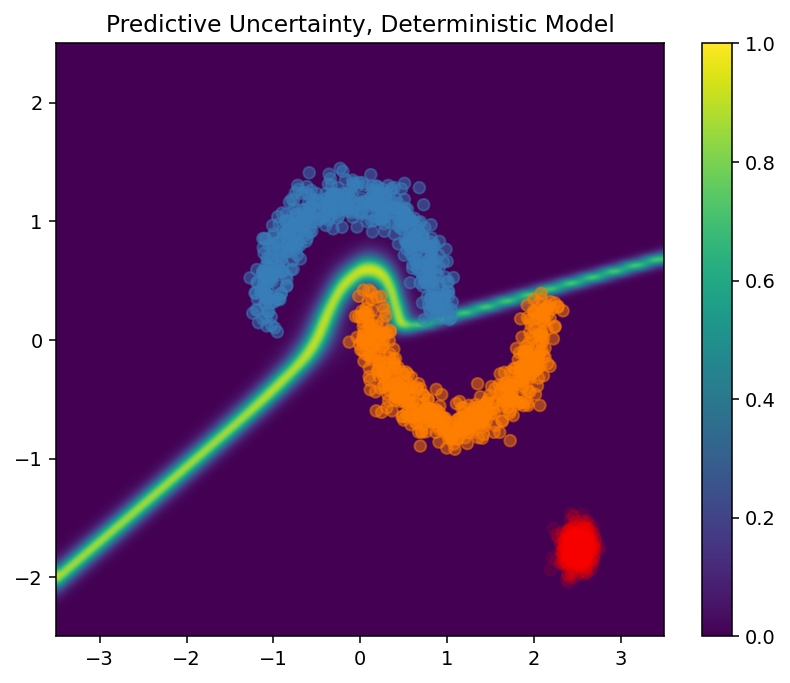

In [16]:
resnet_uncertainty = resnet_probs * (1 - resnet_probs)

_, ax = plt.subplots(figsize=(7, 5.5))
pcm = plot_uncertainty_surface(resnet_uncertainty, ax=ax)
plt.colorbar(pcm, ax=ax)
plt.title("Predictive Uncertainty, Deterministic Model")

plt.show()

Yellow = higher uncertainty
<br>Our deterministic ResNet's uncertainty depends only on the test example's distance from the decision boundary, which makes the model over-confident when out of the training domain

Spectral Norm regularizes W by guiding its spectral norm (largest eigenvalue of W) towards a target
<br>Gaussian Process layer:
 - logits(x) = phi(x) * Beta
 - phi(x) = sqrt(2/M) * cos(Wx + b)

W and b are frozen weights initialized randomly from Gaussian and Uniform distributions respectively
<br>phi(x) are called "random features"
<br> beta is the learnable kernel weight similar to W in a Dense layer

In [17]:
class DeepResNetSNGP(DeepResNet):
  def __init__(self, spec_norm_bound=0.9, **kwargs):
    # put this before super().__init__() so make_dense_layer() has access to self.spec_norm_bound
    self.spec_norm_bound = spec_norm_bound
    super().__init__(**kwargs)

  def make_dense_layer(self):
    dense_layer = super().make_dense_layer()
    # will guide spectral norm of W to target "norm_multiplier"
    return nlp_layers.SpectralNormalization(dense_layer, norm_multiplier=self.spec_norm_bound)

  def make_output_layer(self, num_classes):
    return nlp_layers.RandomFeatureGaussianProcess(
        num_classes,  # dim of output logits
        # +ve value means compute covariance matrix using momentum-based moving average update (similar to batch norm)
        # -1 means update covariance matrix w/o momentum
        gp_cov_momentum=-1,
        **self.classifier_kwargs
    )

  def call(self, inputs, training=False, return_covmat=False):
    logits, covmat = super().call(inputs)

    # return only logits during training, for compatiblity w/ Keras model.fit() API
    if not training and return_covmat: return logits, covmat

    return logits

In [18]:
sngp_model = DeepResNetSNGP(**resnet_config)
sngp_model.build((None, 2))
sngp_model.summary()

Model: "deep_res_net_sngp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             multiple                  384       
                                                                 
 spectral_normalization (Sp  multiple                  16768     
 ectralNormalization)                                            
                                                                 
 spectral_normalization_1 (  multiple                  16768     
 SpectralNormalization)                                          
                                                                 
 spectral_normalization_2 (  multiple                  16768     
 SpectralNormalization)                                          
                                                                 
 spectral_normalization_3 (  multiple                  16768     
 SpectralNormalization)                          

In [19]:
# to reset covmat at every epoch, so covmat can be computed properly
class ResetCovarianceCallback(tf_keras.callbacks.Callback):
  def on_epoch_begin(self, epoch, logs=None):
    if epoch > 0: self.model.classifier.reset_covariance_matrix()

class DeepResNetSNGPWithCovReset(DeepResNetSNGP):
  def fit(self, *args, **kwargs):
    kwargs['callbacks'] = list(kwargs.get('callbacks', []))
    kwargs['callbacks'].append(ResetCovarianceCallback())

    return super().fit(*args, **kwargs)

In [20]:
sngp_model = DeepResNetSNGPWithCovReset(**resnet_config)
sngp_model.compile(**train_config)
sngp_model.fit(train_examples, train_labels, **fit_config)

Epoch 1/100
8/8 [==============================] - 9s 19ms/step - loss: 0.6372 - sparse_categorical_accuracy: 0.9135
Epoch 2/100
8/8 [==============================] - 0s 21ms/step - loss: 0.5413 - sparse_categorical_accuracy: 0.9750
Epoch 3/100
8/8 [==============================] - 0s 20ms/step - loss: 0.4871 - sparse_categorical_accuracy: 0.9940
Epoch 4/100
8/8 [==============================] - 0s 18ms/step - loss: 0.4482 - sparse_categorical_accuracy: 0.9950
Epoch 5/100
8/8 [==============================] - 0s 19ms/step - loss: 0.4169 - sparse_categorical_accuracy: 0.9990
Epoch 6/100
8/8 [==============================] - 0s 18ms/step - loss: 0.3897 - sparse_categorical_accuracy: 1.0000
Epoch 7/100
8/8 [==============================] - 0s 20ms/step - loss: 0.3646 - sparse_categorical_accuracy: 1.0000
Epoch 8/100
8/8 [==============================] - 0s 20ms/step - loss: 0.3442 - sparse_categorical_accuracy: 1.0000
Epoch 9/100
8/8 [==============================] - 0s 22ms/step 

In [21]:
sngp_logits, sngp_covmat = sngp_model(test_examples, return_covmat=True)
sngp_variance = tf.linalg.diag_part(sngp_covmat)[:, None]

Compute posterior predictive probability using Monte Carlo sampling:
E(p(x)) = 1/M sum(logit_m(x))
<br>M is the sample size
<br>logit_m(x) are random samples from SNGP posterior MultivariateNormal(sngp_logits, sngp_covmat)


Approximate the above using mean-field method cuz above can be slow for latency-sensitive apps:
<br>E(p(x)) approx= softmax(logit(x) / sqrt(1 + lambda * sigma^2(x)))
<br>lambda is often chosen as pi/8 or 3/pi^2
<br>sigma^2(x) is the SNGP variance

In [22]:
sngp_logits_adjusted = sngp_logits / tf.sqrt(1. + (np.pi/8.) * sngp_variance)
sngp_probs = tf.nn.softmax(sngp_logits_adjusted, axis=-1)[:, 0]

# above mean-field method is also built-in
def compute_posterior_mean_probability(logits, covmat, lambda_=np.pi/8.):
  logits_adjusted = nlp_layers.gaussian_process.mean_field_logits(logits, covmat, mean_field_factor=lambda_)
  return tf.nn.softmax(logits_adjusted, axis=-1)[:, 0]

In [23]:
sngp_logits, sngp_covmat = sngp_model(test_examples, return_covmat=True)
sngp_probs = compute_posterior_mean_probability(sngp_logits, sngp_covmat)

In [24]:
def plot_predictions(pred_probs, model_name=""):
  """Plot normalized class probabilities and predictive uncertainties."""
  # Compute predictive uncertainty.
  uncertainty = pred_probs * (1. - pred_probs)

  # Initialize the plot axes.
  fig, axs = plt.subplots(1, 2, figsize=(14, 5))

  # Plots the class probability.
  pcm_0 = plot_uncertainty_surface(pred_probs, ax=axs[0])
  # Plots the predictive uncertainty.
  pcm_1 = plot_uncertainty_surface(uncertainty, ax=axs[1])

  # Adds color bars and titles.
  fig.colorbar(pcm_0, ax=axs[0])
  fig.colorbar(pcm_1, ax=axs[1])

  axs[0].set_title(f"Class Probability, {model_name}")
  axs[1].set_title(f"(Normalized) Predictive Uncertainty, {model_name}")

  plt.show()

In [25]:
# put it all in 1 place
def train_and_test_sngp(train_ex, train_labels, test_ex):
  sngp_model = DeepResNetSNGPWithCovReset(**resnet_config)
  sngp_model.compile(**train_config)
  sngp_model.fit(train_ex, train_labels, verbose=0, **fit_config)

  sngp_logits, sngp_covmat = sngp_model(test_ex, return_covmat=True)
  sngp_probs = compute_posterior_mean_probability(sngp_logits, sngp_covmat)

  return sngp_probs

In [26]:
sngp_probs = train_and_test_sngp(train_examples, train_labels, test_examples)

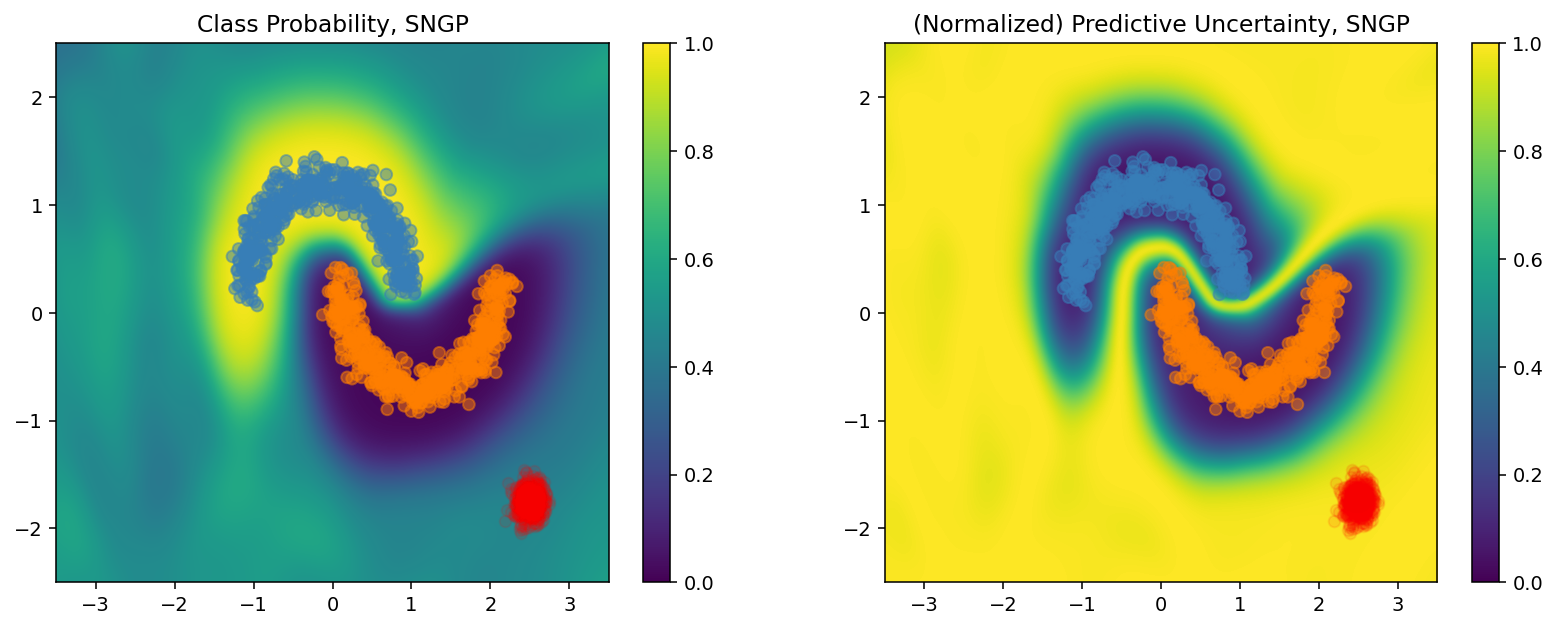

In [27]:
plot_predictions(sngp_probs, model_name='SNGP')

Model becomes less confident as we move away from the training data

Comparison with other techniques:
 - Monte Carlo dropout
 - Deep ensemble

In [28]:
num_ensemble = 10  # both use ensembles (multiple forward passes of deterministic models)

E(p(x)) = 1/M sum(softmax(logit_m(x)))
<br> but average over multiple dropout-enabled forward passes logit_m(x)

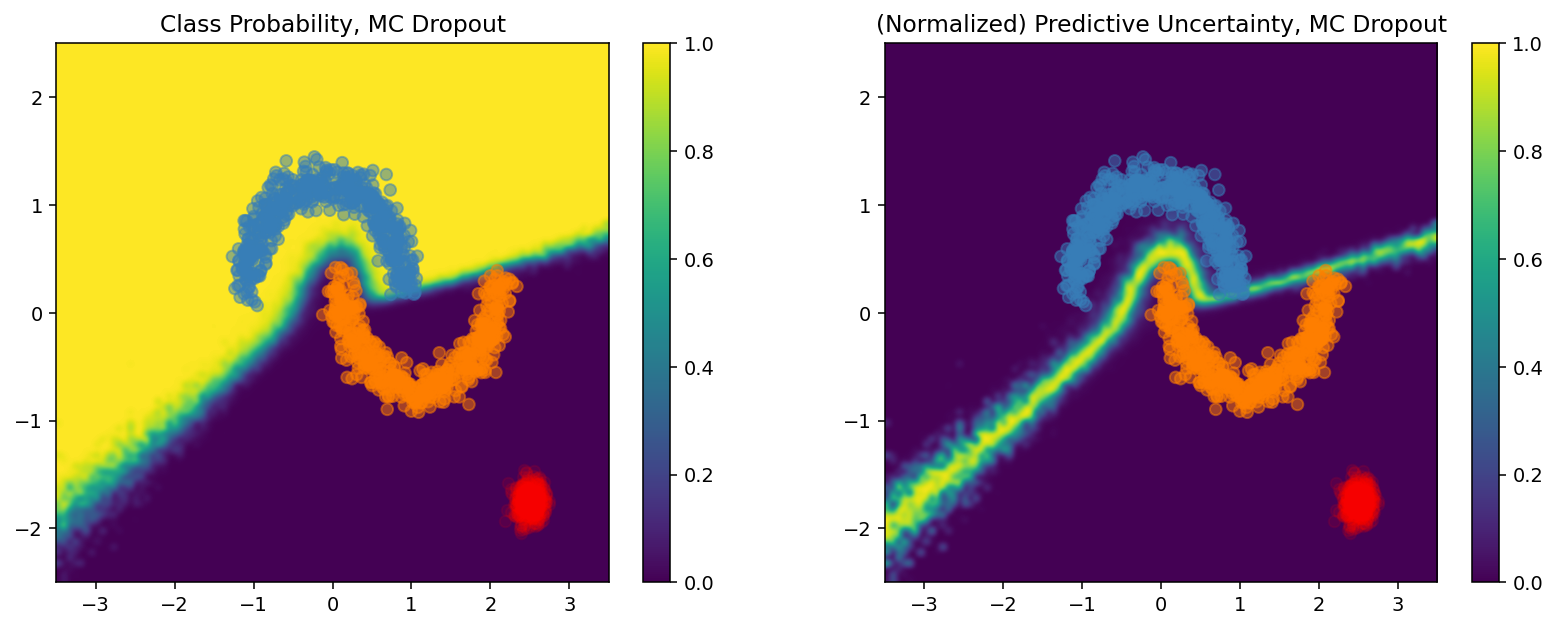

In [29]:
# MC dropout

def mc_dropout_sampling(test_ex):
  return resnet_model(test_ex, training=True)

dropout_logit_samples = [mc_dropout_sampling(test_examples) for _ in range(num_ensemble)]
dropout_prob_samples = [tf.nn.softmax(dropout_logits, axis=-1)[:, 0] for dropout_logits in dropout_logit_samples]
dropout_probs = tf.reduce_mean(dropout_prob_samples, axis=0)

plot_predictions(dropout_probs, model_name="MC Dropout")

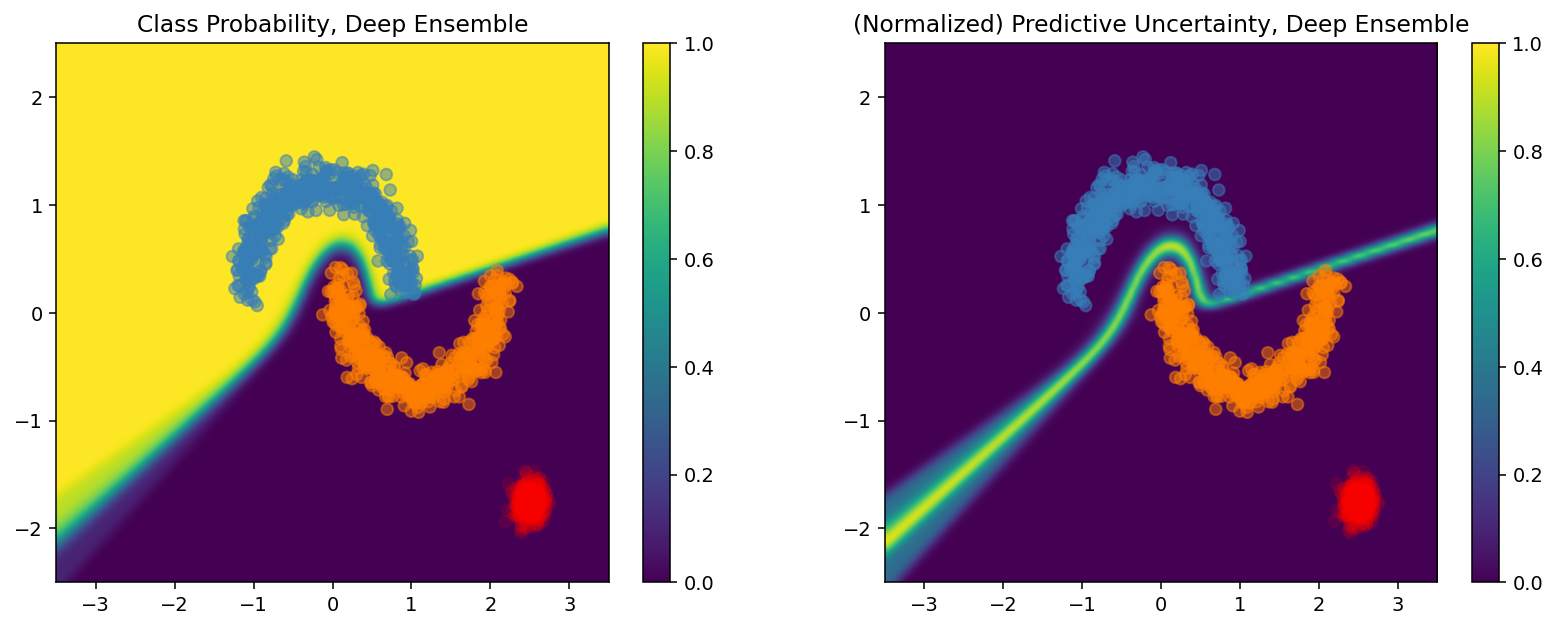

In [32]:
# deep ensemble

resnet_ensemble = []
for _ in range(num_ensemble):
  resnet_model = DeepResNet(**resnet_config)
  resnet_model.compile(**train_config)
  resnet_model.fit(train_examples, train_labels, verbose=0, **fit_config)

  resnet_ensemble.append(resnet_model)

ensemble_logit_samples = [model(test_examples) for model in resnet_ensemble]
ensemble_prob_samples = [tf.nn.softmax(ensemble_logits, axis=-1)[:, 0] for ensemble_logits in ensemble_logit_samples]
ensemble_probs = tf.reduce_mean(ensemble_prob_samples, axis=0)

plot_predictions(ensemble_probs, model_name='Deep Ensemble')

Both improve model's uncertainty by making the decision boundary uncertain, but both lack distance-awareness just like the deterministic model